In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.autograd import Variable
import time

In [13]:
data_dir = 'F:\DataSets/EmotionImages/TargetData'

data_transform = {x: transforms.Compose([transforms.Resize([224, 224]),  # 设置尺寸
                                        transforms.ToTensor(),  # 转为Tensor
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])  # 标准化
                  for x in {"train", "valid"}}  # {"train":"训练集数据格式","valid":"测试集数据格式"}

image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),  # 载入数据
                                         transform = data_transform[x])
                  for x in {"train", "valid"}}  # {"train":"训练集","valid":"测试集"}

dataloader = {x: torch.utils.data.DataLoader(dataset=image_datasets[x],
                                            batch_size=16,
                                            shuffle=True)
              for x in {"train", "valid"}}  # {包装16个为一个批次"train":"训练集数据载入","valid":"测试集数据载入"}

In [14]:
train_data = dataloader["train"]
valid_data = dataloader["valid"]

train_data_size = len(image_datasets["train"])
valid_data_size = len(image_datasets["valid"])

print(train_data_size)
print(valid_data_size)

1848
231


In [4]:
my_model = models.shufflenet_v2_x1_0(pretrained=True)  # 网络预训练好的模型

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\14188/.cache\torch\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|█████████████████████████████████████████████████████████████████████████████| 8.79M/8.79M [00:06<00:00, 1.42MB/s]


In [21]:
print(my_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [16]:
for param in my_model.parameters():
    param.requires_grad = False

In [22]:
# fc_inputs = my_model.fc.in_features
my_model.fc = nn.Sequential(
    nn.Linear(1024, 224),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(224, 3),
    nn.LogSoftmax(dim=1)
)

In [23]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(my_model.parameters())

In [26]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        model = model.cuda()
    history = []
    best_acc = 0.0
    best_epoch = 0
 
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
 
        model.train()
 
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
 
        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            #因为这里梯度是累加的，所以每次记得清零
            optimizer.zero_grad()
 
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            loss.backward()
 
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            train_acc += acc.item() * inputs.size(0)
 
        with torch.no_grad():
            model.eval()
 
            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
 
                loss = loss_function(outputs, labels)
 
                valid_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                valid_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_valid_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
 
        torch.save(model, 'F:\DataSets/modles/'+'shufflenet_v2_x1_0'+str(epoch+1)+'.pt')
    return model, history

In [27]:
num_epochs = 30
trained_model, history = train_and_valid(my_model, loss_func, optimizer, num_epochs)

Epoch: 1/30
Epoch: 001, Training: Loss: 0.5918, Accuracy: 65.5844%, 
		Validation: Loss: 0.5918, Accuracy: 79.2208%, Time: 46.4844s
Best Accuracy for validation : 0.7922 at epoch 001
Epoch: 2/30
Epoch: 002, Training: Loss: 0.4842, Accuracy: 80.6818%, 
		Validation: Loss: 0.4842, Accuracy: 80.5195%, Time: 44.4992s
Best Accuracy for validation : 0.8052 at epoch 002
Epoch: 3/30
Epoch: 003, Training: Loss: 0.4271, Accuracy: 81.6558%, 
		Validation: Loss: 0.4271, Accuracy: 81.8182%, Time: 44.3653s
Best Accuracy for validation : 0.8182 at epoch 003
Epoch: 4/30
Epoch: 004, Training: Loss: 0.4126, Accuracy: 82.8463%, 
		Validation: Loss: 0.4126, Accuracy: 83.1169%, Time: 44.2122s
Best Accuracy for validation : 0.8312 at epoch 004
Epoch: 5/30
Epoch: 005, Training: Loss: 0.3933, Accuracy: 83.5498%, 
		Validation: Loss: 0.3933, Accuracy: 81.8182%, Time: 44.1843s
Best Accuracy for validation : 0.8312 at epoch 004
Epoch: 6/30
Epoch: 006, Training: Loss: 0.4308, Accuracy: 83.2792%, 
		Validation: Lo

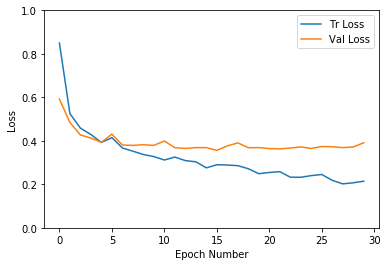

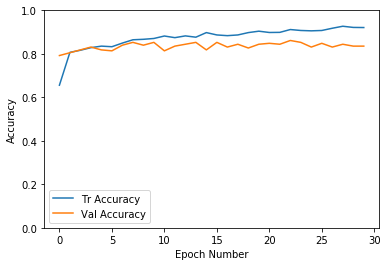

In [28]:
torch.save(history, 'F:\DataSets/modles/history/'+'shufflenet_v2_x1_0' + '_history.pt')
# history = torch.load('F:\DataSets/modles/'+'mobilenet_' + 'history.pt')
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
# plt.savefig('resnet101_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4]) 
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# plt.savefig('resnet101_accuracy_curve.png')
plt.show()